# Airbnb Recommender System - Preprocessing & Modeling

## Introduction

In the previous stages of work we cleaned a European dataset and prepared it for EDA analysis, in the EDA analysis we answered some questions about **city features** and **residences features**.

In relation with **city features** we observed that there were very significant differences in terms of total cost of living and Local purchasing power between cities, also there were significant differences in terms of pollution, amenities, social culture and population. All the features analyzed allowed in some way or another to make at least 2 clusters of cities.

In relation with the **residences features** we observed that price was a good feature to cluster cities in up to 3 different groups, such as low price cities, average price cities and expensive cities. Also, we identified that the number of beds, bedrooms and accommodates was not a very good way of creating clusters, as most cities have a similar distribution of these features. Lastly, regarding ratings of residences, we observed that most residences had very similar and high ratings, all in between 85/100 scale or 9/10 scale, which make it difficult ot cluster them.

Therefore, we will focus in our recommender system work in the city features as the main way to create clusters of cities. This will probably be the main driver of our recommendations to users. Once that the users have been recommended a city, based on different city features, we will then sort out the most similar residences in terms of residence features to them.

By doing this, the host will be able to select which features they prefer to rely on in terms of being recommended a city. As an example, two cities can be recommended, one with similar city amenities and other with similar city pollution. Each host will then be able to see different residences being recommended under each of these features. By doing this we give more freedom of choice to the user in term of selecting what features are relevant or not to them.

## Scope of work

The scope of this work is to start with a clean dataset of residences features and city features, merge it and apply and test different algorithms to the set in order to define the most similar residences. As a result of this, we expect to identify the best algorithm and proceed to move to the modelling stage of the project to visualize the results.


## Import libraries

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from dataclasses import make_dataclass
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
import shap
import scipy

## Load Files

In [212]:
#dataframe with residences and feature/host residences
df = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\dataset_final.csv')
url = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\final_info.csv')
#dataframes with cities features
economy = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\economic.csv')
crime = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\crime.csv')
amenities = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\amenities.csv')
hostility = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\hostility.csv')
pollution = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\pollution.csv')
pop_fem = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\population female.csv')
pop_male = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\population male.csv')
pop = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\population.csv')
rat_fem = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\ratio female.csv')
rat_male = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Airbnb Recommender System - Capstone Project\Notebooks\Data\residences\ratio male.csv')

In [213]:
#convert values of dkk and  pounds to euros in Copenhagen and London
#Covert the Copenhagen residences to euros from Danish Crown (1 euro = 0.13 DKK)
df['Price'] = np.where(df['City'] == 'Copenhagen', df['Price']*0.13, df['Price'])
df['Weekly Price'] = np.where(df['City'] == 'Copenhagen', df['Weekly Price']*0.13, df['Weekly Price'])
df['Monthly Price'] = np.where(df['City'] == 'Copenhagen', df['Monthly Price']*0.13, df['Monthly Price'])

df['Security Deposit'] = np.where(((df['City'] == 'Copenhagen') & (df['Security Deposit'] != 0)), df['Security Deposit']*0.13, df['Security Deposit'])
df['Cleaning Fee'] = np.where(((df['City'] == 'Copenhagen') & (df['Cleaning Fee'] != 0)), df['Cleaning Fee']*0.13, df['Cleaning Fee'])
df['Extra People'] = np.where(((df['City'] == 'Copenhagen') & (df['Extra People'] != 0)), df['Extra People']*0.13, df['Extra People'])

#Convert the London residences to euros from Pounds (1 euro = 0.86 Pound)
df['Price'] = np.where(df['City'] == 'London', df['Price']/0.86, df['Price'])
df['Weekly Price'] = np.where(df['City'] == 'London', df['Weekly Price']/0.86, df['Weekly Price'])
df['Monthly Price'] = np.where(df['City'] == 'London', df['Monthly Price']/0.86, df['Monthly Price'])

df['Security Deposit'] = np.where(((df['City'] == 'London') & (df['Security Deposit'] != 0)), df['Security Deposit']/0.86, df['Security Deposit'])
df['Cleaning Fee'] = np.where(((df['City'] == 'London') & (df['Cleaning Fee'] != 0)), df['Cleaning Fee']/0.86, df['Cleaning Fee'])
df['Extra People'] = np.where(((df['City'] == 'London') & (df['Extra People'] != 0)), df['Extra People']/0.86, df['Extra People'])

In [214]:
##add additional column with total price = price + cleaning fee
df['total_price_day'] = df['Price'] + df['Cleaning Fee']
df['total_price_week'] = df['Weekly Price'] + df['Cleaning Fee']
df['total_price_month'] = df['Monthly Price'] + df['Cleaning Fee']

In [215]:
df.columns

Index(['ID', 'Host ID', 'Name', 'Summary', 'Description', 'Country', 'City',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Host pic', 'Host verified', 'Host superhost',
       'Instant book', 'Req guest phone', 'Req guest pic', 'Req license',
       'First Review', 'Last Review', 'Number of Reviews',
       'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'Age', 'Price',
       'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Cancellation Policy',
       'country_city', 'total_price_day', 'total_price_week',
       'total_price_month'],
      dtype='object')

In [216]:
#for final recommender list
url_final = url[['ID','Listing Url','Host URL']]

In [6]:
df.dtypes

ID                               int64
Host ID                          int64
Name                            object
Summary                         object
Description                     object
Country                         object
City                            object
Property Type                   object
Room Type                       object
Accommodates                   float64
Bathrooms                      float64
Bedrooms                       float64
Beds                           float64
Bed Type                        object
Host pic                         int64
Host verified                    int64
Host superhost                   int64
Instant book                     int64
Req guest phone                  int64
Req guest pic                    int64
Req license                      int64
First Review                    object
Last Review                     object
Number of Reviews              float64
Review Scores Rating           float64
Review Scores Accuracy   

In [7]:
#convert string columns to string
df[['Name', 'Summary', 'Description','Country','City','Age']] = df[['Name', 'Summary', 'Description','Country','City','Age']].astype('string')
df[['Property Type','Room Type','Bed Type','Cancellation Policy','Host pic', 'Host verified', 'Host superhost',
       'Instant book', 'Req guest phone', 'Req guest pic', 'Req license']] = df[['Property Type','Room Type','Bed Type','Cancellation Policy','Host pic', 'Host verified', 'Host superhost',
       'Instant book', 'Req guest phone', 'Req guest pic', 'Req license']].astype('category')
#make age column an integer
df['Age'] = df['Age'].str.replace(' days', '')
df[['Age']] = df[['Age']].astype('int')
#drop some columns
df.drop(columns=['First Review','Last Review','country_city'],inplace=True)

In [8]:
df.set_index('ID', inplace=True)

In [9]:
df.columns

Index(['Host ID', 'Name', 'Summary', 'Description', 'Country', 'City',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Host pic', 'Host verified', 'Host superhost',
       'Instant book', 'Req guest phone', 'Req guest pic', 'Req license',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'Age', 'Price',
       'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Cancellation Policy',
       'total_price_day', 'total_price_week', 'total_price_month'],
      dtype='object')

In [10]:
#for this prototype we are going to drop some columns. In future upgrades we will add them
df_preprocessing = df.drop(columns=['Host ID', 'Name', 'Summary', 'Description', 'Country', 'City', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'Age', 'Price',
       'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee',
    'Extra People', 'Cancellation Policy',], axis= 1)

In [11]:
df_preprocessing

,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Host pic,Host verified,Host superhost,Instant book,Req guest phone,Req guest pic,Req license,Number of Reviews,Review Scores Rating,Guests Included,total_price_day,total_price_week,total_price_month
ID,,,,,,,,,,,,,,,,,,,,
15802051,House,Private room,2.0,1.0,2.0,2.0,Real Bed,1,0,0,0,0,0,0,3.0,93.0,1.0,51.162791,358.139535,1534.883721
14751869,House,Entire home/apt,8.0,1.5,4.0,4.0,Real Bed,1,1,1,1,0,0,0,21.0,95.0,1.0,237.209302,1206.976744,4924.418605
8901485,Apartment,Private room,2.0,1.0,1.0,1.0,Real Bed,1,1,0,0,0,0,0,0.0,0.0,1.0,81.395349,569.767442,2441.860465
5832248,Apartment,Entire home/apt,6.0,1.0,2.0,4.0,Real Bed,1,0,0,0,0,0,0,2.0,100.0,1.0,110.465116,598.837209,2470.930233
8049784,House,Private room,2.0,1.0,1.0,1.0,Real Bed,1,0,0,0,0,0,0,3.0,93.0,1.0,29.069767,203.488372,872.093023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610162,Apartment,Entire home/apt,2.0,1.0,1.0,2.0,Real Bed,1,1,0,0,0,0,0,14.0,85.0,1.0,80.000000,462.000000,1613.000000
13760682,Apartment,Entire home/apt,5.0,2.5,2.0,3.0,Real Bed,1,1,0,0,0,0,0,4.0,100.0,4.0,500.000000,2900.000000,12100.000000
9173969,Apartment,Shared room,1.0,0.5,1.0,1.0,Real Bed,1,0,0,0,0,0,0,0.0,0.0,1.0,0.000000,0.000000,0.000000


In [12]:
pd.set_option('display.max_colwidth', -1)

C:\Users\34658\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [13]:
print(list(df_preprocessing['Property Type'].unique()))

['House', 'Apartment', 'Other', 'Hostel', 'Cabin', 'Townhouse', 'Bed & Breakfast', 'Dorm', 'Loft', 'Condominium', 'Boutique hotel', 'Guesthouse', 'Boat', 'Serviced apartment', 'Ryokan (Japan)', 'Villa', 'Tent', 'Tipi', 'Bungalow', 'Castle', 'Chalet', 'Timeshare', 'Island', 'Camper/RV', 'Hut', 'Lighthouse', 'Guest suite', 'In-law', 'Cave', 'Yurt', 'Treehouse', 'Vacation home', 'Earth House', 'Casa particular', 'Nature lodge', 'Train', 'Igloo', 'Parking Space', 'Car', 'Pension (Korea)']


In [14]:
print(list(df_preprocessing['Room Type'].unique()))

['Private room', 'Entire home/apt', 'Shared room']


In [15]:
print(list(df_preprocessing['Bed Type'].unique()))

['Real Bed', 'Couch', 'Pull-out Sofa', 'Futon', 'Airbed']


In [16]:
print(list(df['Cancellation Policy'].unique()))

['strict', 'moderate', 'flexible', 'super_strict_60', 'super_strict_30', 'strict_new', 'flexible_new', 'moderate_new', 'super_strict_60_new', 'super_strict_30_new', 'no_refunds']


In [17]:
df_preprocessing.dtypes

Property Type           category
Room Type               category
Accommodates            float64 
Bathrooms               float64 
Bedrooms                float64 
Beds                    float64 
Bed Type                category
Host pic                category
Host verified           category
Host superhost          category
Instant book            category
Req guest phone         category
Req guest pic           category
Req license             category
Number of Reviews       float64 
Review Scores Rating    float64 
Guests Included         float64 
total_price_day         float64 
total_price_week        float64 
total_price_month       float64 
dtype: object

In [18]:
#drop additional column in cities
economy.drop('Unnamed: 0', inplace=True, axis=1)
crime.drop('Unnamed: 0', inplace=True, axis=1)
amenities.drop('Unnamed: 0', inplace=True, axis=1)
hostility.drop('Unnamed: 0', inplace=True, axis=1)
pollution.drop('Unnamed: 0', inplace=True, axis=1)
pop.drop('Unnamed: 0', inplace=True, axis=1)

In [19]:
#sort values by City
economy.sort_values('City', inplace=True)
crime.sort_values('City', inplace=True)
amenities.sort_values('City', inplace=True)
hostility.sort_values('City', inplace=True)
pollution.sort_values('City', inplace=True)

In [20]:
#set of indexes to cities
economy.set_index('City', inplace=True)
crime.set_index('City', inplace=True)
amenities.set_index('City', inplace=True)
hostility.set_index('City', inplace=True)
pollution.set_index('City', inplace=True)

In [21]:
#normalization of economy features
normalized_df=(economy-economy.min())/(economy.max()-economy.min())
economy_norm = normalized_df

In [22]:
#normalization of crime and safety indexes
normalized_df=(crime-crime.min())/(crime.max()-crime.min())
crime_norm = normalized_df

In [23]:
#normalization of pollution indexes
pollution2 = pollution.iloc[:,[3,4]]
normalized_df=(pollution2-pollution2.min())/(pollution2.max()-pollution2.min())
pollution_norm = normalized_df
pollution_final = pd.concat([pollution, pollution_norm],axis=1)
pollution_final = pollution_final.iloc[:,[0,1,2,5,6]]

In [24]:
#create a single dataframe of city features
city_features = pd.concat([economy_norm,crime_norm,pollution_final,hostility, amenities], axis=1)

## Step 1 - Clustering cities based on city features similarity

We will proceed to make clusters based on the selected city features. As an example, below is the representation of Cost of Living vs. Local Purchasing Power. If these two features were selected as relevant, these datapoints would be the input that we would use for the clustering.

Bear in mind that the most features added, the more information clusters will consider, but also, as all city features weight the same, recommendations can be more misleading. (e.g. If user selects, cost of life, Purchasing power and sport amenities, the cluster of cities will consider as same importance the relative position of the city compared to others in those 3 spectrums and can recommend a city with very similar sport amenities but that is +20% more expensive in terms of cost of living).

## Definition of city features

In [25]:
## define metrics economy
cost_life = 'Cost of Living Index'
purch_power = 'Local Purchasing Power Index'
cost_life_rent = 'Cost of Living Plus Rent Index'
cost_groceries = 'Groceries Index'
cost_restaurants = 'Restaurant Price Index'

## define metrics crime
crime_index = 'Crime Index'
safety_index = 'Safety Index'

## define metrics amenities
public_tt = 'norm_score_pub_transport'
green_places = 'norm_score_green_places'
sports = 'norm_score_sports'
cultural = 'norm_score_cultural'
public_spaces = 'norm_score_public_spaces'

## define metrics hostility
general = 'score_norm_general'
ethnic = 'score_norm_ethnic'
gay = 'score_norm_gay'
immigrants = 'score_norm_immigrants'
young_fam = 'score_norm_young_families'
elder = 'score_norm_elderly'

## define metrics pollution
air_pollution = 'air_score_norm'
noise_pollution = 'noise_score_norm'
cleanliness = 'clean_score_norm'

## Inputs of the model
### Input 1 of 4: Select your city
Select your city:
* 'Amsterdam', 'Antwerp', 'Athens', 'Barcelona', 'Berlin', 'Brussels',
* 'Copenhagen', 'Dublin', 'Geneva', 'London', 'Madrid', 'Manchester',
* 'Paris', 'Rome', 'Vienna'

In [26]:
my_city = 'Amsterdam'

### Input 2 of 4: Select your relevant city features
Select the city features that you consider relevant. You can pick more than one city feature from the list below

#### Economic city features
* **cost_life** = find cities similar to yours in terms of **cost of living (excluded rent cost and mortgages)**.
* **purch_power** = find cities similar to yours in terms of **average purchasing power** of individuals.
* **cost_life_rent** = find cities similar to yours in terms of **total cost of living (rent and mortgages included)**
* **cost_groceries** = find cities similar to yours in terms of the **cost of groceries**.
* **cost_restaurants** = find cities similar to yours in terms of the **cost of restaurants and bars**.

#### Crime and Safety city features
* **crime_index** = finds cities similar to yours in terms of **crime rates**.
* **safety_index** = finds cities similar to yours in terms of **safety rates**.

#### Amenities city features
* **public_tt** = find cities similar to yours in terms of **how satified locals are with public transport** in the city.
* **green_places** = find cities similar to yours in terms of **how satified locals are with green areas and parks** in the city.
* **sports** = find cities similar to yours in terms of **how satified locals are with sport amenities** in the city.
* **cultural** = find cities similar to yours in terms of **how satified locals are with cultural amenities** in the city.
* **public_spaces** = find cities similar to yours in terms of **how satified locals are with public spaces, streets and plazas** in the city.

#### Hostility of city towards certain groups
* **general** = find cities similar to yours in terms of how much locals believe that the **general population will enjoy living** in the city.
* **ethnic** = find cities similar to yours in terms of how much locals believe that **ethnic minorities will enjoy living** in the city.
* **gay** = find cities similar to yours in terms of how much locals believe that **gay and lesbian population will enjoy living** in the city.
* **immigrants** = find cities similar to yours in terms of how much locals believe that **immigrant population will enjoy living** in the city.
* **young_fam** = find cities similar to yours in terms of how much locals believe that **young families with children will enjoy living** in the city.
* **elder** = find cities similar to yours in terms of how much locals believe that **elder population will enjoy living** in the city.

#### Pollution city metrics
* **air_pollution** = find cities similar to yours in terms of **how satisfied are locals with the air pollution** in the city.
* **noise_pollution** = find cities similar to yours in terms of **how satisfied are locals with the noise levels** in the city.
* **cleanliness** = find cities similar to yours in terms of **how satisfied are locals with the overall cleanliness** in the city.

In [27]:
relevant_city_features = [cost_life,purch_power]

## Filtering best cities based on city features

In [28]:
#city_clusters dataframe is created according to preferences
city_clusters = city_features[relevant_city_features]
x = city_clusters.loc[:,relevant_city_features]

### Visualize possible optimal k value for k-means

In [29]:
#calculate optimal k value for the subset defined
wcss=[]

for i in range(1,16):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

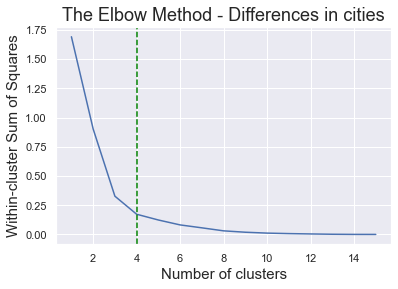

In [79]:
#the elbow method
number_clusters = range(1,16)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method - Differences in cities', fontsize= 18)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Within-cluster Sum of Squares', fontsize=15)
plt.axvline(4, ls='--', color='green')

### Input 3 of 4: Select k value (number of clusters)

Try to select a k value that minimizes the WCSS. The number selected will be the number of clusters generated. If a high number is picked there will be less cities in your final selection, but those cities will be closer to your city features selected. If you pick a lower number there will be more cities in your cluster, but they may be less close to your city features.

In [31]:
number_clusters = 4

## Apply k-means algorithm

In [32]:
#clustering based on the optimal k number observed above
kmeans = KMeans(number_clusters)
#fit of the kmeans
kmeans.fit(x)

KMeans(n_clusters=4)

In [33]:
##Clustering results
identified_clusters = kmeans.fit_predict(x)

In [34]:
data_with_clusters = city_clusters.copy()
data_with_clusters['cluster'] = identified_clusters

## visualize the clusters generated

Below you will see the clusters split in different colors. Intuitively, choose the two features that you want to visualize in the plot:

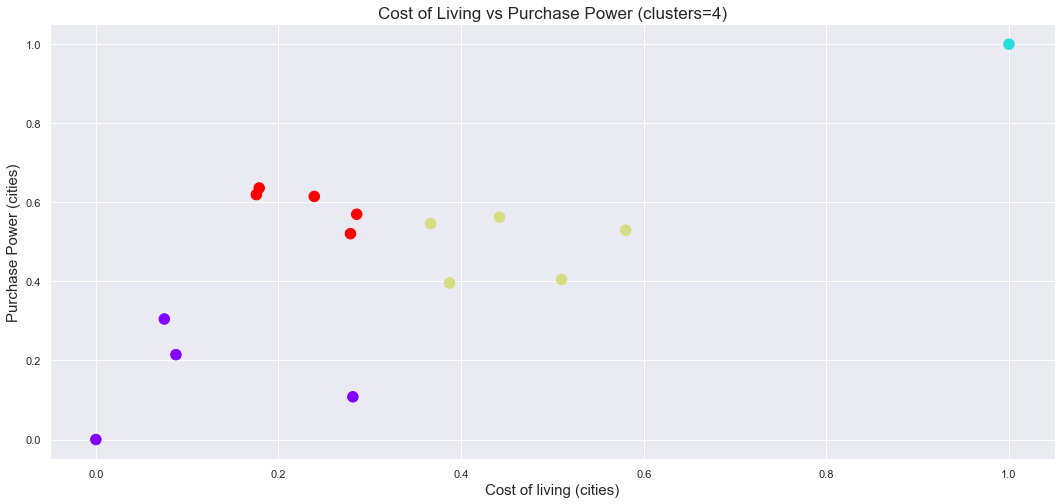

In [263]:
plt.scatter(city_clusters[cost_life], city_clusters[purch_power], c=data_with_clusters['cluster'],cmap='rainbow', s=110)
plt.xlim((np.min(city_clusters[cost_life])-0.05),(np.max(city_clusters[cost_life])+0.05))
plt.ylim((np.min(city_clusters[purch_power])-0.05),(np.max(city_clusters[purch_power])+0.05))
plt.title('Cost of Living vs Purchase Power (clusters=4)',fontsize=17)
plt.xlabel('Cost of living (cities)', fontsize=15)
plt.ylabel('Purchase Power (cities)',fontsize=15)
plt.show()

In [36]:
# filter cities of the cluster of your city
#reset index of cities
data_with_clusters.reset_index(inplace=True)
#get your cluster
my_cluster = int(data_with_clusters.loc[data_with_clusters.City == my_city,'cluster'])
#filter cities
my_city_cluster = list(data_with_clusters[data_with_clusters['cluster']==my_cluster]['City'])

In [37]:
my_city_cluster.remove(my_city)

In [38]:
my_city_cluster

['Copenhagen', 'Dublin', 'London', 'Paris']

## Step 2 - The residence filtering filtering

### Definition of residence and host features

In [39]:
## define price metric
daypr = 'total_price_day'
weekpr = 'total_price_week'
monthpr = 'total_price_month'

#define residence type and size
proptype = 'Property Type'
roomtype = 'Room Type'
nbedroom = 'Bedrooms'
bedtype = 'Bed Type'
nbeds = 'Beds'
nbathroom = 'Bathrooms'

#define number of people allowed
npeople = 'Accommodates'
nguests = 'Guests Included'

#define host type
hpic = 'Host pic'
hver = 'Host verified'
hsup = 'Host superhost'
ibook = 'Instant book'
reqpho = 'Req guest phone'
reqpic = 'Req guest pic'
reqlic = 'Req license'

#define residence rating and number of reviews
nrev = 'Number of Reviews'
rating = 'Review Scores Rating'

### Input 3 of 4: Select your relevant residence features

#### Price features
* **daypr**: Find residences **similar** to yours in terms of **daily price**
* **weekpr**: Find residences **similar** to yours in terms of **weekly price**
* **monthpr**: Find residences **similar** to yours in terms of **monthly price**

*Note: as some hosts have a one-off cleaning fee, we added this fee to the daily, weekly and monthly price. As a result of this, daily prices may differ much more than weekly or monthly prices. If you plan on staying more than a few days, weekly or monthly price metrics may be better to compare your residence to others in terms of price*

#### Residence type and size features
* **proptype**: Find residences **similar** to yours in terms of **property type**
* **roomtype**: Find residences **similar** to yours in terms of **room type**
* **nbathroom**: Find residences **similar** to yours in terms of **number of bathrooms**
* **nbedroom**: Find residences **similar** to yours in terms of **number of bedrooms**
* **nbeds**: Find residences **similar** to yours in terms of **number of beds**
* **bedtype**: Find residences **similar** to yours in terms of **type of bed**

#### Number of people and guests allowed
* **npeople**: Find residences **similar** to yours in terms of **number of people allowed**
* **nguests**: Find residences **similar** to yours in terms of **how many temporary guests** are **allowed** (besides nº of people)

#### Host Characteristics
* **hpic**: Find residences with **hosts** similar to you in that you both **have (or not) profile picture**
* **hver**: Find residences with **hosts** similar to you in that you both **are (or not) verified**
* **hsup**: Find residences with **hosts** similar to you in that you both **are (or not) superhosts**
* **ibook**: Find residences **hosts** similar to you in that you both **allow (or not) instant bookings**
* **reqpho**: Find residences with **hosts** similar to you in that you both **require (or not) guests phone numbers**
* **reqpic**: Find residences with **hosts** similar to you in that you both **require (or not) guests profile picture**
* **reqlic**: Find residences with **hosts** similar to you in that you both **require (or not) license to host**

#### Reviews
* **nrev**: Find residences **similar** to yours based on the **number of reviews** received by guests
* **rating**: Find residences **similar** to yours based on the **overall rating** received by previous guests

In [40]:
relevant_residence_features = [weekpr,proptype,roomtype,bedtype,nbedroom,nbeds,npeople,nrev,rating]

### Create dataframe with relevant features and filter

#### Filter the dataframe based on the cities clustered

In [41]:
df_set = df[df['City'].isin(my_city_cluster)]

In [42]:
#### Select the relevant features for the clustering
df_set_features = df_set[relevant_residence_features]

In [43]:
df_set_features.head()

,total_price_week,Property Type,Room Type,Bed Type,Bedrooms,Beds,Accommodates,Number of Reviews,Review Scores Rating
ID,,,,,,,,,
15802051,358.139535,House,Private room,Real Bed,2.0,2.0,2.0,3.0,93.0
14751869,1206.976744,House,Entire home/apt,Real Bed,4.0,4.0,8.0,21.0,95.0
8901485,569.767442,Apartment,Private room,Real Bed,1.0,1.0,2.0,0.0,0.0
5832248,598.837209,Apartment,Entire home/apt,Real Bed,2.0,4.0,6.0,2.0,100.0
8049784,203.488372,House,Private room,Real Bed,1.0,1.0,2.0,3.0,93.0


In [44]:
### reset dataframe
df_set_features.reset_index(inplace=True)

### Add your residence information to the dataframe in this order.
* For **ID (literal)**: *'my residence'*
* For **total_price_week (in euros)**: your weekly residence price in euros
* For **Property type (choose one, preferably House or Apartment)**: *'House', 'Apartment', 'Other', 'Hostel', 'Cabin', 'Townhouse', 'Bed & Breakfast', 'Dorm', 'Loft', 'Condominium', 'Boutique hotel', 'Guesthouse', 'Boat', 'Serviced apartment', 'Ryokan (Japan)', 'Villa', 'Tent', 'Tipi', 'Bungalow', 'Castle', 'Chalet', 'Timeshare', 'Island', 'Camper/RV', 'Hut', 'Lighthouse', 'Guest suite', 'In-law', 'Cave', 'Yurt', 'Treehouse', 'Vacation home', 'Earth House', 'Casa particular', 'Nature lodge', 'Train', 'Igloo', 'Parking Space', 'Car', 'Pension (Korea)'*
* For **Room type (choose one)**: *'Private room', 'Entire home/apt', 'Shared room'*
* For **Bed Type (choose one)**: *'Real Bed', 'Couch', 'Pull-out Sofa', 'Futon', 'Airbed'*
* For **Bedrooms**: the number of bedrooms of your residence
* For **Beds**: the number of beds of your residence
* For **Accomodates**: the number of accomodates of your residence
* For **Number of Reviews**: the current number of reviews of your airbnb residence
* For **Review Scores Rating**: the review score, from 0 to 100, of your airbnb resdience

In [45]:
ID_me = 'my_residence'
total_price_week = 500
property_type = 'House'
room_type = 'Private room'
bed_type = 'Real Bed'
bedrooms = 2
beds = 2
accommodates = 4
number_of_reviews = 3
reviews_score = 95

In [46]:
df_set_features.head()

,ID,total_price_week,Property Type,Room Type,Bed Type,Bedrooms,Beds,Accommodates,Number of Reviews,Review Scores Rating
0,15802051,358.139535,House,Private room,Real Bed,2.0,2.0,2.0,3.0,93.0
1,14751869,1206.976744,House,Entire home/apt,Real Bed,4.0,4.0,8.0,21.0,95.0
2,8901485,569.767442,Apartment,Private room,Real Bed,1.0,1.0,2.0,0.0,0.0
3,5832248,598.837209,Apartment,Entire home/apt,Real Bed,2.0,4.0,6.0,2.0,100.0
4,8049784,203.488372,House,Private room,Real Bed,1.0,1.0,2.0,3.0,93.0


In [47]:
df_set_features.loc['ID'] = [ID_me,total_price_week,property_type,room_type,bed_type,bedrooms,beds,accommodates,number_of_reviews,reviews_score]

C:\Users\34658\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
df_set_features.set_index('ID', inplace=True)

In [49]:
df_set_features.dtypes

total_price_week        float64
Property Type           object 
Room Type               object 
Bed Type                object 
Bedrooms                float64
Beds                    float64
Accommodates            float64
Number of Reviews       float64
Review Scores Rating    float64
dtype: object

In [50]:
#change datatypes
df_set_features[['Property Type','Room Type','Bed Type']] = df_set_features[['Property Type','Room Type','Bed Type']].astype('category')

C:\Users\34658\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
df_set_features.dtypes

total_price_week        float64 
Property Type           category
Room Type               category
Bed Type                category
Bedrooms                float64 
Beds                    float64 
Accommodates            float64 
Number of Reviews       float64 
Review Scores Rating    float64 
dtype: object

In [52]:
scaled_features = df_set_features.copy()
col_names = ['total_price_week', 'Bedrooms','Beds','Accommodates','Number of Reviews','Review Scores Rating']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
df_set_features_scaled = scaled_features

In [55]:
df_set_features_scaled.tail()

,total_price_week,Property Type,Room Type,Bed Type,Bedrooms,Beds,Accommodates,Number of Reviews,Review Scores Rating
ID,,,,,,,,,
13760682,3.819088,Apartment,Entire home/apt,Real Bed,0.963963,1.177211,1.198623,-0.357982,0.781675
9173969,-1.235302,Apartment,Shared room,Real Bed,-0.272318,-0.630254,-1.234022,-0.502346,-1.633577
13754942,0.035267,Apartment,Entire home/apt,Real Bed,0.963963,1.177211,-0.017699,-0.394073,0.781675
8642835,-0.689776,Apartment,Private room,Real Bed,-0.272318,-0.630254,-0.625861,-0.466255,0.781675
my_residence,-0.363855,House,Private room,Real Bed,0.963963,0.273478,0.590462,-0.394073,0.660912


In [56]:
df_set_features_scaled.dtypes

total_price_week        float64 
Property Type           category
Room Type               category
Bed Type                category
Bedrooms                float64 
Beds                    float64 
Accommodates            float64 
Number of Reviews       float64 
Review Scores Rating    float64 
dtype: object

## Definition of residence and host features

## Filtering residences based on residence features

In [57]:
#residence_clusters dataframe is created according to preferences
x = df_set_features_scaled

### Visualize possible optimal k value for k-means

In [65]:
#calculate optimal k value for the subset defined
cost=[]

for i in range(1,20):
    print('{i}\.cluster start'.format(i=i))
    kprototypes = KPrototypes(n_clusters = i,n_jobs=-1,verbose=1, init='Huang', n_init=10)
    kprototypes.fit(x, categorical=[1,2,3])
    cost_iter = kprototypes.cost_
    cost.append(cost_iter)

1\.cluster start
Best run was number 1
2\.cluster start
Best run was number 3
3\.cluster start
Best run was number 5
4\.cluster start
Best run was number 4
5\.cluster start
Best run was number 2
6\.cluster start
Best run was number 2
7\.cluster start
Best run was number 2
8\.cluster start
Best run was number 9
9\.cluster start
Best run was number 8
10\.cluster start
Best run was number 1
11\.cluster start
Best run was number 9
12\.cluster start
Best run was number 7
13\.cluster start
Best run was number 5
14\.cluster start
Best run was number 8
15\.cluster start
Best run was number 1
16\.cluster start
Best run was number 4
17\.cluster start
Best run was number 7
18\.cluster start
Best run was number 9
19\.cluster start
Best run was number 2


(0.0, 20.0)

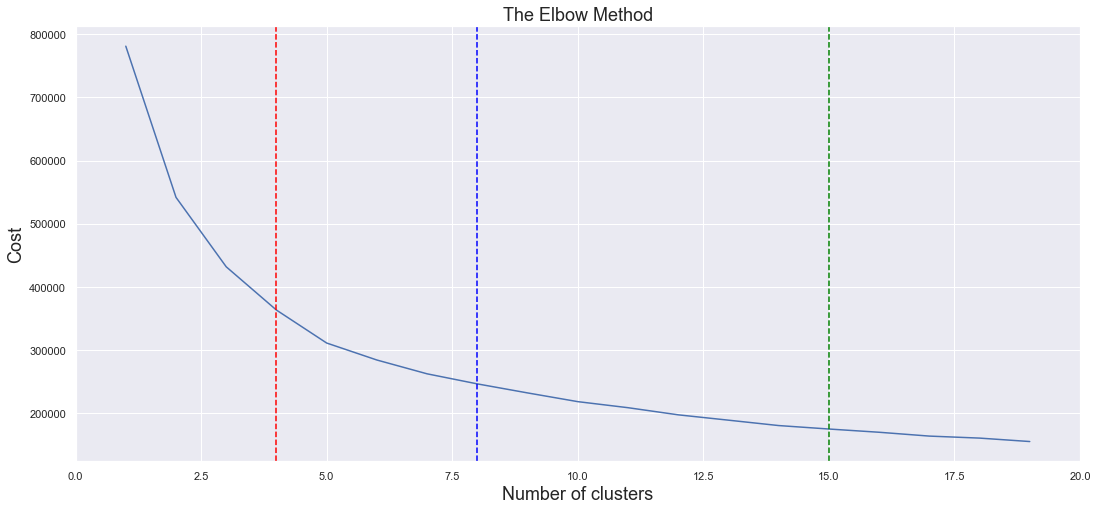

In [264]:
#the elbow method
number_clusters2 = range(1,20)
sns.set(rc={'figure.figsize':(18,8)})
plt.plot(number_clusters2, cost)
plt.title('The Elbow Method',fontsize=18)
plt.xlabel('Number of clusters', fontsize=18)
plt.ylabel('Cost', fontsize=18)
plt.axvline(4, ls='--',color='red')
plt.axvline(8, ls='--',color='blue')
plt.axvline(15, ls='--',color='green')
plt.xlim(0,20)

### Input 3 of 4: Select k value (number of clusters)

Try to select a k value that minimizes the WCSS. The number selected will be the number of clusters generated. If a high number is picked there will be less residences in your final selection, but those cities will be closer to your residence features selected. If you pick a lower number there will be more residences in your cluster, but they may be less close to your residence features.

In [85]:
number_clusters2 = 25

## Apply k-Prototypes algorithm

In [87]:
#clustering based on the optimal k number observed above
kproto = KPrototypes(n_clusters=number_clusters2, init='Huang', n_jobs=-1, n_init=10, verbose=1,random_state=47)
kproto.fit(x, categorical=[1,2,3])
centroids = kproto.cluster_centroids_
labels= kproto.labels_

Best run was number 9


In [ ]:
df['Labels'] = labels

In [ ]:
data_with_clusters2 = residence_clusters.copy()
data_with_clusters2['cluster'] = identified_clusters2

## visualize the clusters generated

Below you will see the clusters split in different colors. Intuitively, choose the two features that you want to visualize in the plot:

In [ ]:

plt.scatter(residence_clusters[npeople], residence_clusters[nbeds], c=data_with_clusters2['cluster'],cmap='rainbow')
plt.xlim((np.min(residence_clusters[npeople])-0.05),(np.max(residence_clusters[npeople])+0.05))
plt.ylim((np.min(residence_clusters[nbeds])-0.05),(np.max(residence_clusters[nbeds])+0.05))
plt.title('number of people vs number of beds')
plt.xlabel('number of people')
plt.ylabel('number of beds')
plt.show()

## Calculate quality of the clusters created

We will assess the quality of the clusters generated by running a classifier on the clusters as labels, and determining the level of accuracy of our predictions. The better defined the clusters are, the higher the accuracy score will be.

In [88]:
x['Labels'] = labels

In [89]:
x.head()

,total_price_week,Property Type,Room Type,Bed Type,Bedrooms,Beds,Accommodates,Number of Reviews,Review Scores Rating,Labels
ID,,,,,,,,,,
15802051,-0.611103,House,Private room,Real Bed,0.963963,0.273478,-0.625861,-0.394073,0.612607,15
14751869,0.868330,House,Entire home/apt,Real Bed,3.436526,2.080943,3.023107,0.255568,0.660912,22
8901485,-0.242258,Apartment,Private room,Real Bed,-0.272318,-0.630254,-0.625861,-0.502346,-1.633577,19
5832248,-0.191592,Apartment,Entire home/apt,Real Bed,0.963963,2.080943,1.806784,-0.430164,0.781675,16
8049784,-0.880643,House,Private room,Real Bed,-0.272318,-0.630254,-0.625861,-0.394073,0.612607,15


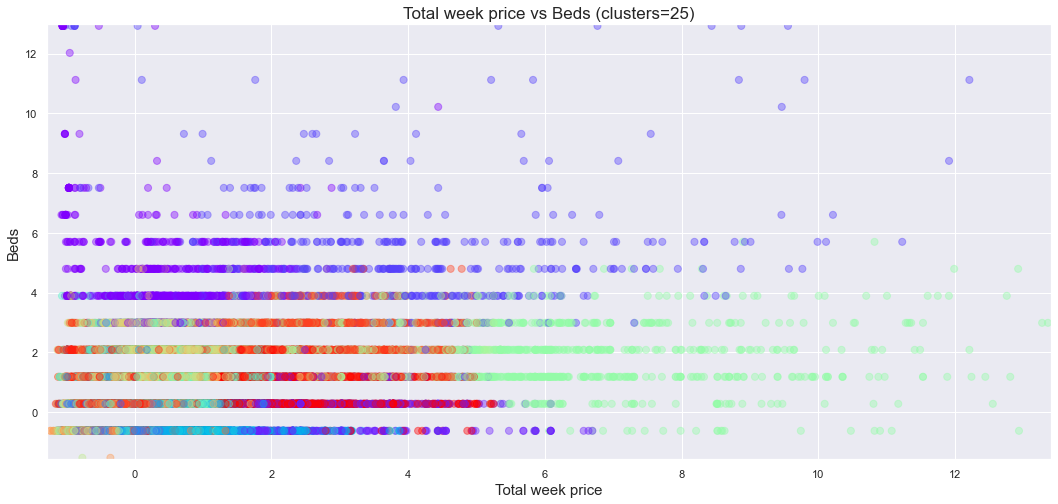

In [260]:
sns.set(rc={'figure.figsize':(18,8)})
plt.scatter(x['total_price_week'], x['Beds'], c=x['Labels'],cmap='rainbow', s=50,alpha=.4)
plt.xlim((np.min(x['total_price_week'])-0.05),(np.max(x['total_price_week'])+0.05))
plt.ylim((np.min(x['Beds'])-0.05),(np.max(x['Beds'])+0.05))
plt.title('Total week price vs Beds (clusters=25)',fontsize=17)
plt.xlabel('Total week price', fontsize=15)
plt.ylabel('Beds',fontsize=15)
plt.show()

## Fit the model


In [97]:
clusters = x.copy()

In [102]:
clusters['Labels'] = clusters['Labels'].astype('category')

In [103]:
clusters.dtypes

total_price_week        float64 
Property Type           category
Room Type               category
Bed Type                category
Bedrooms                float64 
Beds                    float64 
Accommodates            float64 
Number of Reviews       float64 
Review Scores Rating    float64 
Labels                  category
dtype: object

In [119]:
X = clusters.iloc[:,1:8]
y = clusters.iloc[:,-1]

In [120]:
clf_kp = LGBMClassifier(colsample_bytree=0.8, n_jobs=-1)

In [121]:
cv_scores_kp = cross_val_score(clf_kp, X, y, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.44172907487727714


The classifier could accurately predict 44% of the residences in their clusters. Lower values of F1 score may be an indicator that we used too many clusters in the experiment. We will try with lower k number of clusters in future versions of the project to help better classify the residences.

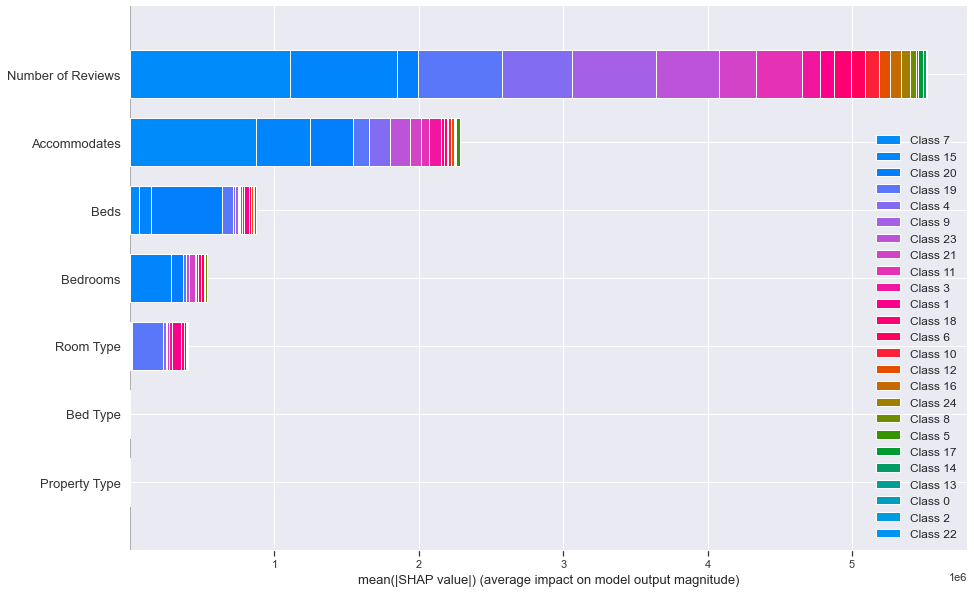

In [122]:
clf_kp.fit(X, y)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(X)
shap.summary_plot(shap_values_kp, X, plot_type="bar", plot_size=(15, 10))

The most relevant features for the model are Number of Reviews as well as Accomodates. The model did not use for clustering Bed Type or Property type, in future version of the model, we will try different combinations of features to help cluster, as well as a lower number of clusters to make the clustering cleaner and more understandable.

## Output of the model

We will show the most similar residences to ours.

In [218]:
final_recommendation = x.copy()

In [219]:
final_recommendation.reset_index(inplace=True)

In [220]:
recommended_residences = final_recommendation[final_recommendation['Labels'] == 11]

In [221]:
recommended_residences.shape

(8581, 11)

In [222]:
my_row = recommended_residences[recommended_residences['ID'] == 'my_residence']
rest_row = recommended_residences[recommended_residences['ID'] != 'my_residence']

In [223]:
my_row.set_index('ID', inplace=True)
rest_row.set_index('ID', inplace=True)

In [224]:
closest_price = rest_row['total_price_week'].sub(float(my_row[['total_price_week']].values)).abs().nsmallest(5)
closest_price

ID
11570020    0.0
2504482     0.0
6987332     0.0
5555235     0.0
4927689     0.0
Name: total_price_week, dtype: float64

In [225]:
df_final = pd.DataFrame(closest_price)

In [226]:
df_final.reset_index(inplace=True)

In [227]:
list_recommendations = list(df_final['ID'])

In [228]:
df.columns

Index(['ID', 'Host ID', 'Name', 'Summary', 'Description', 'Country', 'City',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Host pic', 'Host verified', 'Host superhost',
       'Instant book', 'Req guest phone', 'Req guest pic', 'Req license',
       'First Review', 'Last Review', 'Number of Reviews',
       'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'Age', 'Price',
       'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Cancellation Policy',
       'country_city', 'total_price_day', 'total_price_week',
       'total_price_month'],
      dtype='object')

In [229]:
retrieve = df.copy()

In [230]:
retrieve.reset_index(inplace=True)

In [231]:
list_recommendations

[11570020, 2504482, 6987332, 5555235, 4927689]

In [233]:
final_set = retrieve[retrieve['ID'].isin(list_recommendations)][['ID','City','Name','Description','Property Type','Room Type','total_price_week']]

In [236]:
final_set.set_index('ID',inplace=True)

In [235]:
url_final.set_index('ID',inplace=True)

In [242]:
recommendations = pd.concat([final_set, url_final], axis=1, join='inner')

In [244]:
pd.set_option('display.width', 1000)

In [247]:
recommendations_house = recommendations[['City','Name','Description','Room Type','total_price_week']]
recommendations_contact = recommendations[['City','Name','Listing Url','Host URL']]

## The Best 5 residences
### Home information

In [248]:
recommendations_house

,City,Name,Description,Room Type,total_price_week
ID,,,,,
11570020,London,Lovely & warm flat 12 mins from central London,"Clapham North has amazing restaurants, bars and open space in the form if Clapham Common. The tube is about 60 seconds walk away. That takes you to central London in 10 minutes. Flat is neat and spacious with outside space, wifi, tv etc Anywhere Can offer travel and tourist tips Great restaurants, bars and an amazing park nearby. Super quick to central London! Clapham North tube station is 1 minute away and Clapham High Street overground station is 2 minutes away",Entire home/apt,500.0
2504482,Paris,Joli trois-pièces avec vue,"Ce trois-pièces, lumineux, calme et spacieux vous accueille tout près de la Place d'Italie et vous offre une magnifique sur tout Paris. A quelques minutes des métros Olympiades, Nationale, Place d'Italie. Nombreux commerces de qualité à proximité. Grand trois-pièces de 70m2, situé au 15è étage d'une tour particulièrement calme du 13ème arrondissement, cet appartement comporte une grande entrée, une cuisine/pièce-à-vivre, un salon, une chambre parentale (grand lit de 180cm composé de deux lits/sommiers de 90cm, suffisamment de place pour installer un lit bébé), une chambre pour un ou deux enfants, une salle de bain, des toilettes séparées. Notre quartier, situé entre la Place d'Italie, la Butte aux Cailles et le quartier des Gobelins, est à la fois populaire, calme et vivant. En quelques minutes de marche, vous aurez accès à de très bons commerces de bouche (excellents boulangers, fabuleux caviste et fromager par exemple) à de délicieux restaurants asiatiques, italiens, grecques ou tou",Entire home/apt,500.0
6987332,Paris,Appartement Paris Centre (9ème),"Bel appartement du centre ville parisien (place Clichy) situé au 2e étage avec ascenseur. Haut de plafond, l'appartement est un F2-3 situé dans un quartier charismatique : Grands boulevards, Montmartre et Pigalle sont accessibles à pied. L'appartement est un F2-3 : il dispose d'une chambre indépendante (lit double), d'une autre chambre (lit double) en mezzanine donnant sur le salon, lui-même ouvert sur la cuisine avec bar. WC et salle de bain séparés. Wifi, linge de lit et nécessaire de cuisine sont inclus (plaques à induction, micro-ondes, four, réfrigérateur...). Laverie automatique située à une rue. Toutes les pièces seront accessibles aux voyageurs. Nous ne serons pas sur place pendant la période où nous souhaitons mettre à disposition notre appartement, nous serons alors joignables par téléphone en cas de besoin. Pouvons nous déplacer si problème. Quartier dynamique et riche, la place de Clichy est un lieu très accessible en tout point : à pied vous vous situez à 15 minutes des G",Entire home/apt,500.0
5555235,Paris,Quiet & Bright flat,"Well located in Paris intra-muros (2 min' from Olympiades Line 14 - 8' minutes from Place d'Italie, Lines 5, 6, 7). The 74 m² flat is in a 70's building, at the 26th floor (crazy view!). It has recently been refurbished.",Entire home/apt,500.0
4927689,London,Lovely 2-floor 2 bedroom garden flat in Islington,"Split level basement flat in large Victorian town house, with excellent transport links. The flat consists of large double bedroom leading out to a garden area, second single bedroom, separate WC and shower, open plan living/dining/kitchen area. This is a great space with two large bedrooms. The living area works well for dining, relaxing and entertaining. There is also a decent size patio/garden area, great for eating out when it gets a bit warmer. Some things to consider when making your booking. A couple of guests have said that the ceilings in the lower floor are a bit lower than the pictures, but also that they are perfectly reasonable. Could get a bit tricky if you are 6'5 (1.95m) plus maybe. Some guests have also pointed out that they could hear noise from the house above from time to time, as they floorboards aren't soundproof. Again none have said that this necessarily impacted their s

### Contact information

In [249]:
recommendations_contact

,City,Name,Listing Url,Host URL
ID,,,,
11570020,London,Lovely & warm flat 12 mins from central London,https://www.airbnb.com/rooms/11570020,https://www.airbnb.com/users/show/27348595
2504482,Paris,Joli trois-pièces avec vue,https://www.airbnb.com/rooms/2504482,https://www.airbnb.com/users/show/7035807
6987332,Paris,Appartement Paris Centre (9ème),https://www.airbnb.com/rooms/6987332,https://www.airbnb.com/users/show/23116772
5555235,Paris,Quiet & Bright flat,https://www.airbnb.com/rooms/5555235,https://www.airbnb.com/users/show/24411952
4927689,London,Lovely 2-floor 2 bedroom garden flat in Islington,https://www.airbnb.com/rooms/4927689,https://www.airbnb.com/users/show/4891639
